In [1]:
import time
import random
import tensorflow as tf
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, Concatenate, AveragePooling2D, MaxPooling2D, GlobalMaxPool2D, Lambda, Reshape, Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras import losses
from tensorflow.keras import metrics 
from matplotlib import pyplot
from tensorflow.python.autograph.pyct import transformer



In [4]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g



In [5]:
def defing_generator(latent_size, image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape)
    style_image = Input(shape=image_shape)
    # stack content and style images
    stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(stacked_layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_constraint=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #ouutput layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model


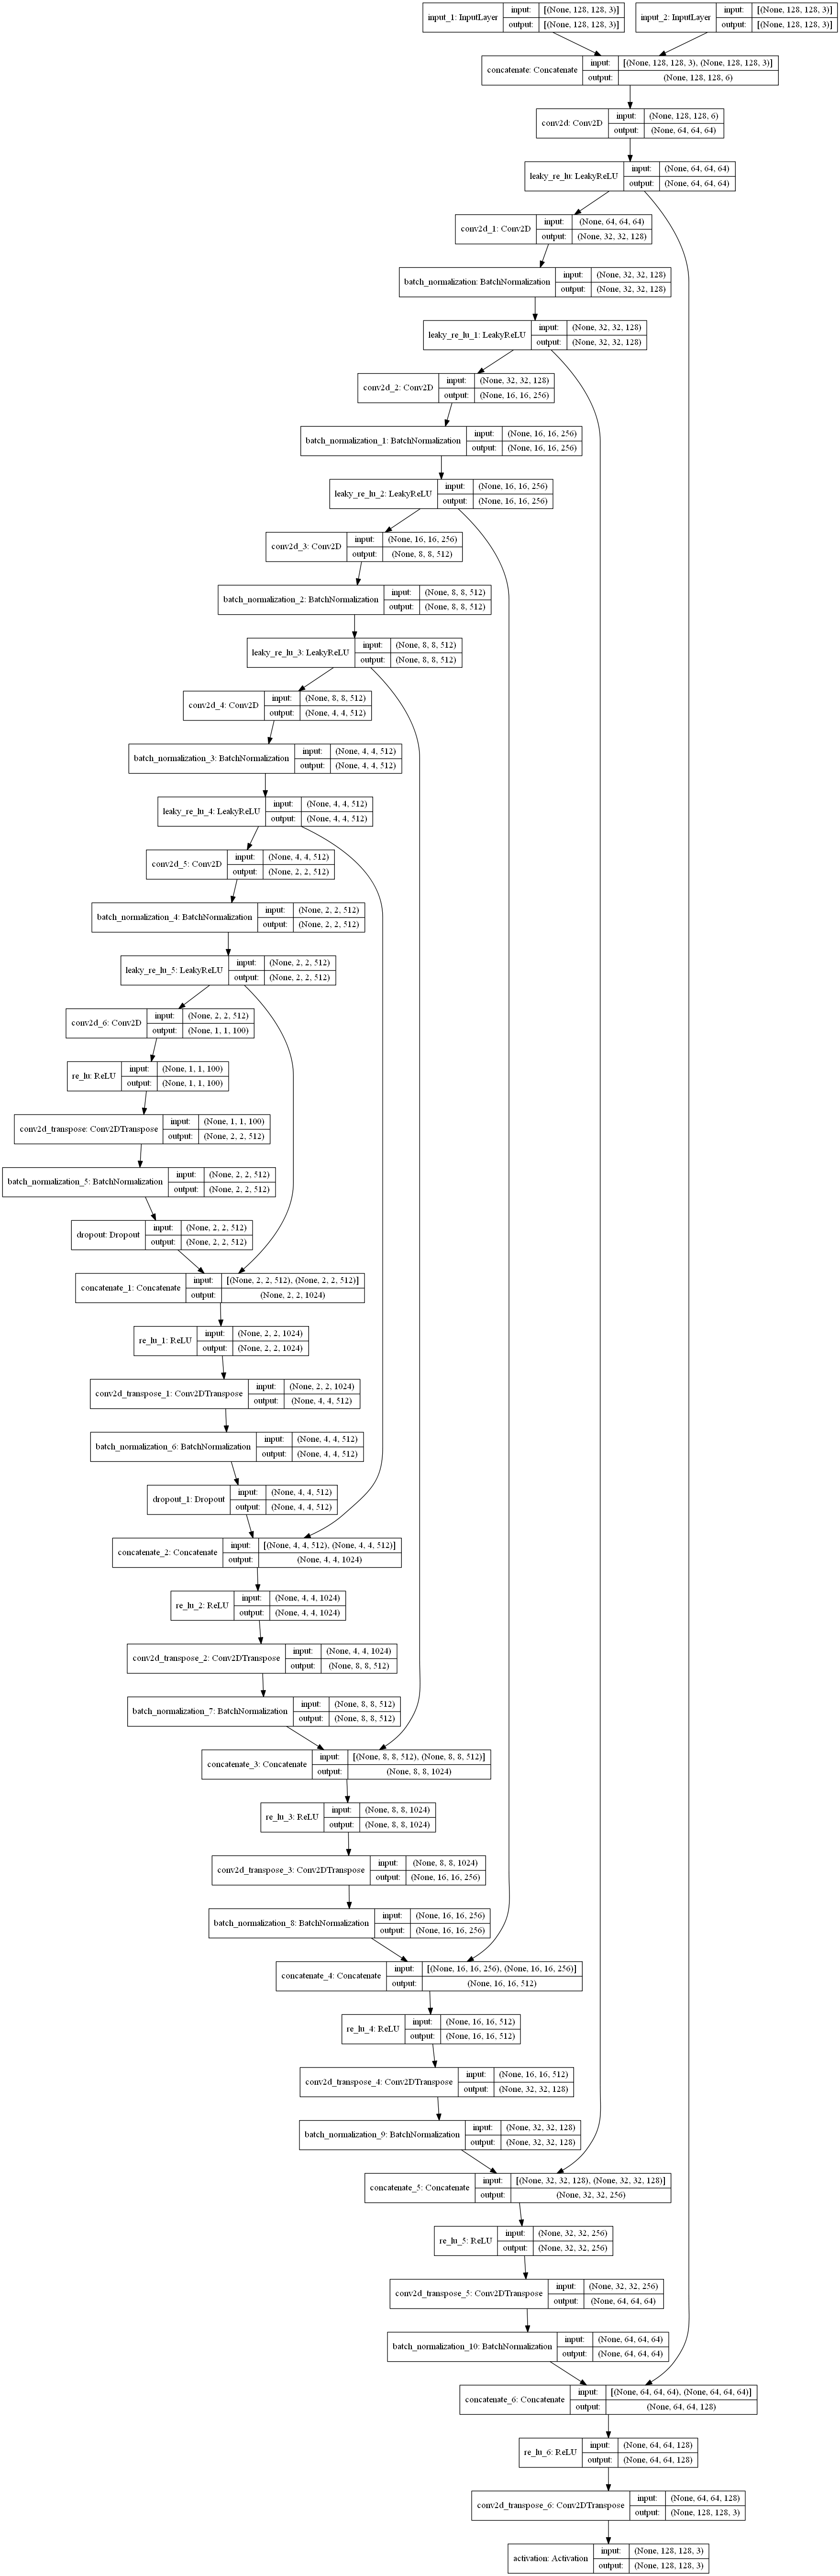

In [6]:

g_model = defing_generator(100)
tf.keras.utils.plot_model(g_model, show_shapes=True)


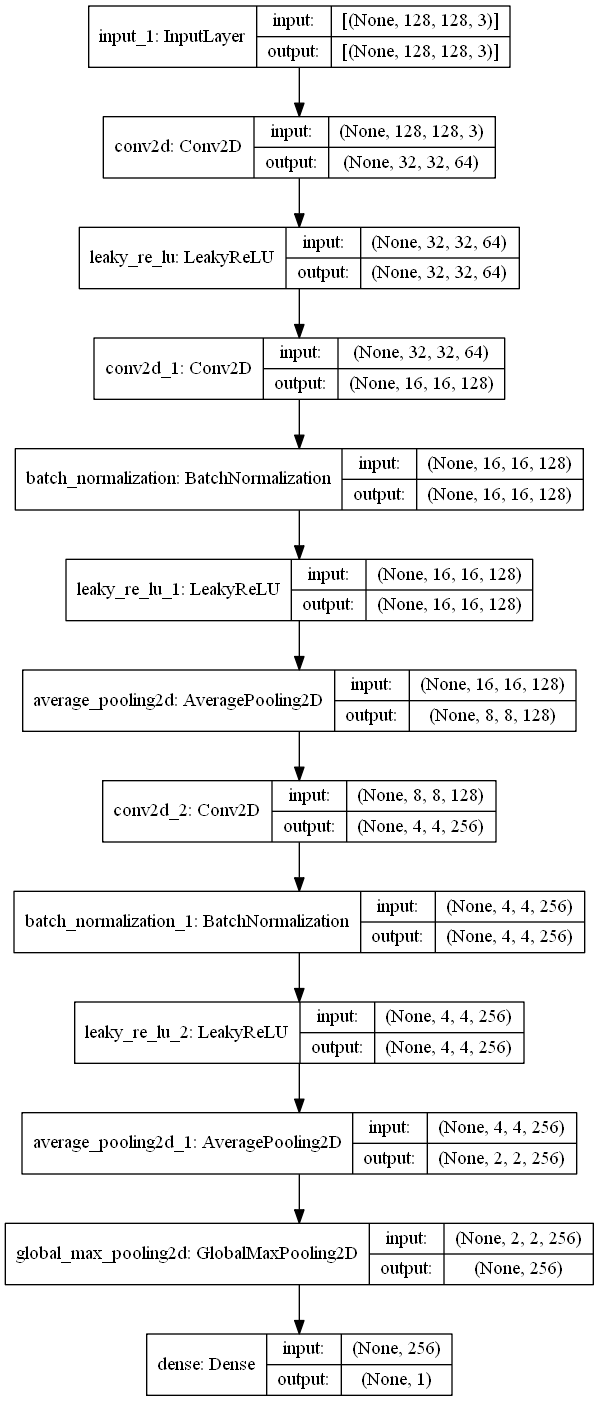

In [2]:
def define_style_descrminator(image_size=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    input_img = Input(shape=image_size)
    # C64
    d = Conv2D(64, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(input_img)
    d = LeakyReLU(alpha=0.2)(d)
	# C128
    d = Conv2D(128, (4, 4), (2, 2), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
	# C256
    d = Conv2D(256, (4, 4), (2, 2), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
    # flatten
    flt = GlobalMaxPool2D()(d)
    # linear logits layer
    output = Dense(1)(flt)
    #build and compile the model
    model = Model(inputs=input_img, outputs=output, name='style_descriminator')
    return model

dss_model = define_style_descrminator()
tf.keras.utils.plot_model(dss_model, show_shapes=True)


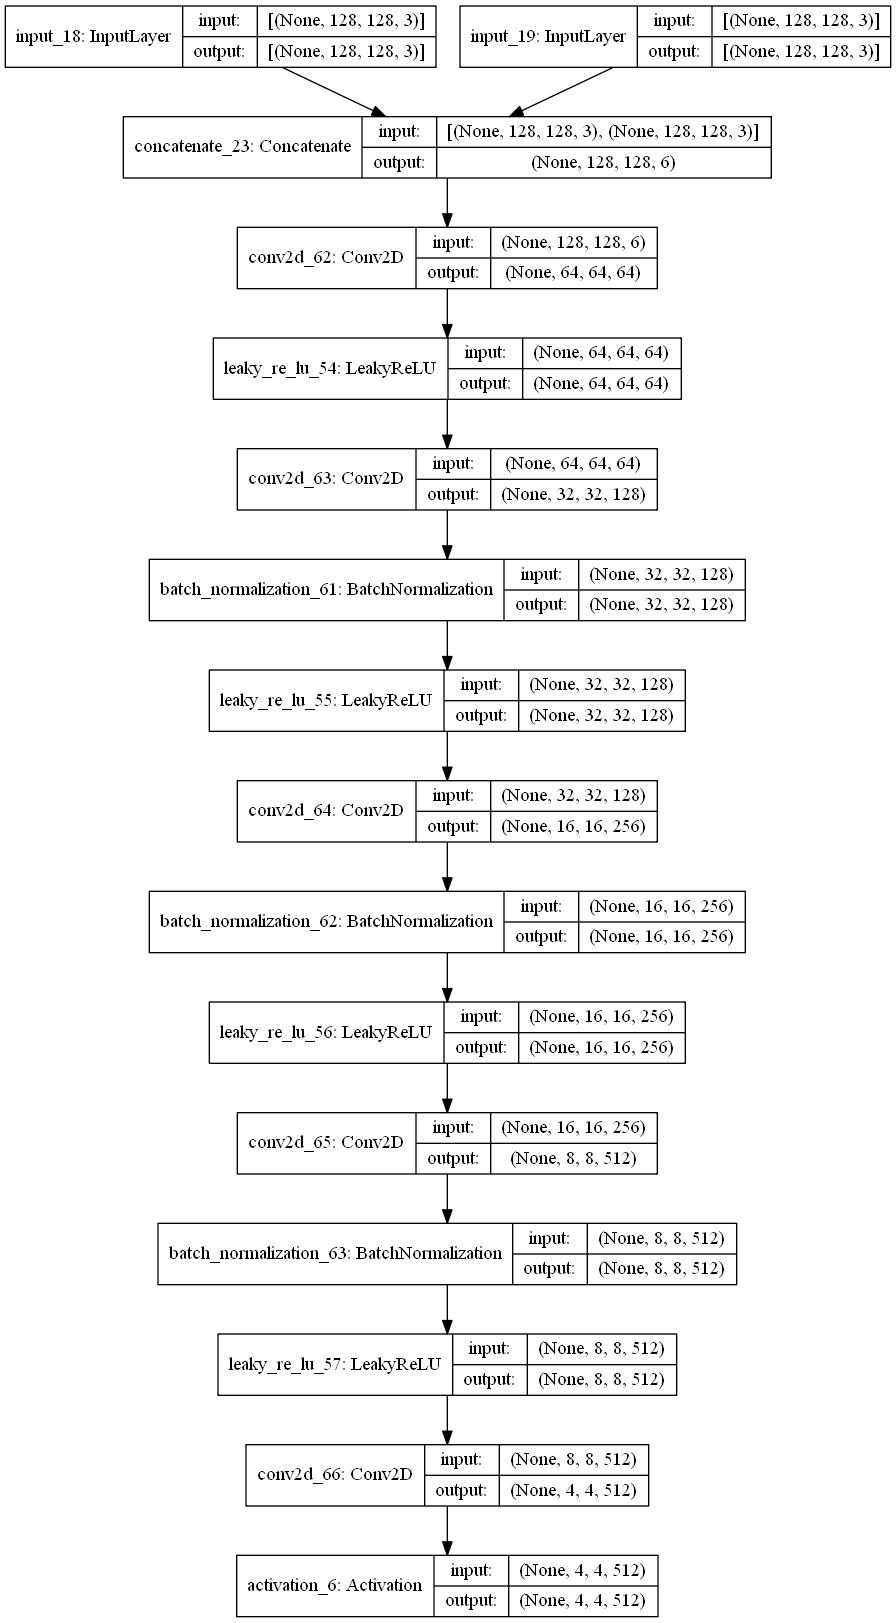

In [29]:
def define_cnt_descriminator(image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    #content image input
    in_cnt_image = Input(shape=image_shape)
    #transfer image input 
    in_tr_image = Input(shape=image_shape)
    #concatnate image channel-wise
    merged = Concatenate()([in_cnt_image, in_tr_image])
    # c64
    d = Conv2D(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # c128
    d = Conv2D(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c256
    d = Conv2D(256, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    #define model
    model = Model(inputs=[in_cnt_image, in_tr_image], outputs=patch_out, name='content_descriminator')
    return model

dsc_model = define_cnt_descriminator()
tf.keras.utils.plot_model(dsc_model, show_shapes=True)


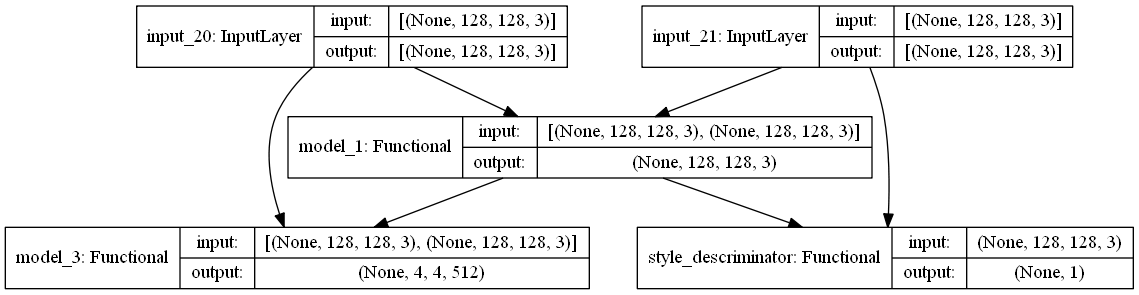

In [32]:
def define_gan(g_model, dc_model, ds_model, image_shape=(128, 128, 3)):
    for layer in dc_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    
    for layer in ds_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # input layer for GAN model
    cnt_img = Input(shape=image_shape)
    style_img = Input(shape=image_shape)
    # generator model
    gen_out = g_model([cnt_img, style_img])
    # style descriminator model
    dss_out = ds_model(style_img)
    dst_out = ds_model(gen_out)
    # content descriminator model
    cnt_out = dc_model([cnt_img, gen_out])
    model = Model(inputs=[cnt_img, style_img], outputs=[gen_out,  dss_out, dst_out, cnt_out])
    return model

gan_model = define_gan(g_model, dsc_model, dss_model)
tf.keras.utils.plot_model(gan_model, show_shapes=True)


In [17]:
def define_style_descrminator(output_size,image_shape):
    vgg16_feature_net = tf.keras.applications.VGG16(include_top=False, input_shape=image_shape)
    for layer in vgg16_feature_net.layers:
        layer.trainable = False
    feature_map = vgg16_feature_net.output
    x = GlobalMaxPool2D()(feature_map)
    x = Dropout(rate=0.5)(x)
    x = Dense(512, activation='relu')(x)
    logits = Dense(output_size, use_bias=False)(x)
    model = Model(inputs=vgg16_feature_net.input, outputs=logits)
    return model

In [18]:
dss_model = define_style_descrminator(64, (128, 128, 3))
dss_model.summary()
#tf.keras.utils.plot_model(dss_model, show_shapes=True)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [29]:
class StyleNet(tf.keras.Model):

    def __init__(self, base_model):
        super(StyleNet, self).__init__()
        self._model = base_model 

    @tf.function
    def call(self, inputs):
        ref_img, trans_img = inputs
        with tf.name_scope("Style") as scope:
            ft1 = self._model(ref_img)
            ft1 = tf.math.l2_normalize(ft1, axis=-1)
        with tf.name_scope("Transfer") as scope:
            ft2 = self._model(trans_img)
            ft2 = tf.math.l2_normalize(ft2, axis=-1)
        return [ft1, ft2]
    
    @tf.function
    def get_features(self, inputs):
        return tf.math.l2_normalize(self._model(inputs), axis=-1)


In [32]:
model = StyleNet(dss_model)
#model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [31]:
out = model([tf.zeros((32, 128, 128, 3)), tf.zeros((32, 128, 128, 3))])

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Style/model_9/block1_conv1/Relu (defined at <ipython-input-25-b2816da2a338>:11) ]] [Op:__inference_call_4228]

Function call stack:
call


In [3]:
vgg16_feature_net = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))
vgg16_feature_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [16]:
def define_cnt_descriminator(image_shape=(128, 128, 3), train_weights=True):
    vgg16_base_model = tf.keras.applications.VGG16(include_top=False, input_shape=image_shape)
    if not train_weights:
        for layer in vgg16_base_model.layers:
            layer.trainable = False
    base_model_out = vgg16_base_model.get_layer('block4_pool').output
    model = Model(inputs=vgg16_base_model.input, outputs=base_model_out)
    return model


In [17]:
cnt_model = define_cnt_descriminator()
cnt_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [8]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [9]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

# img_batch = K.zeros(shape=(8, 128, 128, 3), dtype='float32')
# Wavelet(img_batch)

In [11]:
def get_wavelet_cnn_model(input_shape=(128, 128, 3)):

    #input_shape = 224, 224, 3

    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = Concatenate()([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = Concatenate()([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = Concatenate()([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 

    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(2, activation='softmax', name='fc_7')(drop_6)

    model = Model(inputs=input_, outputs=output)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')

    return model

In [12]:
dss_model = get_wavelet_cnn_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 64, 64, 12), 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 64, 64, 64)   6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 64, 64, 64)   256         conv_1[0][0]                     
______________________________________________________________________________________________

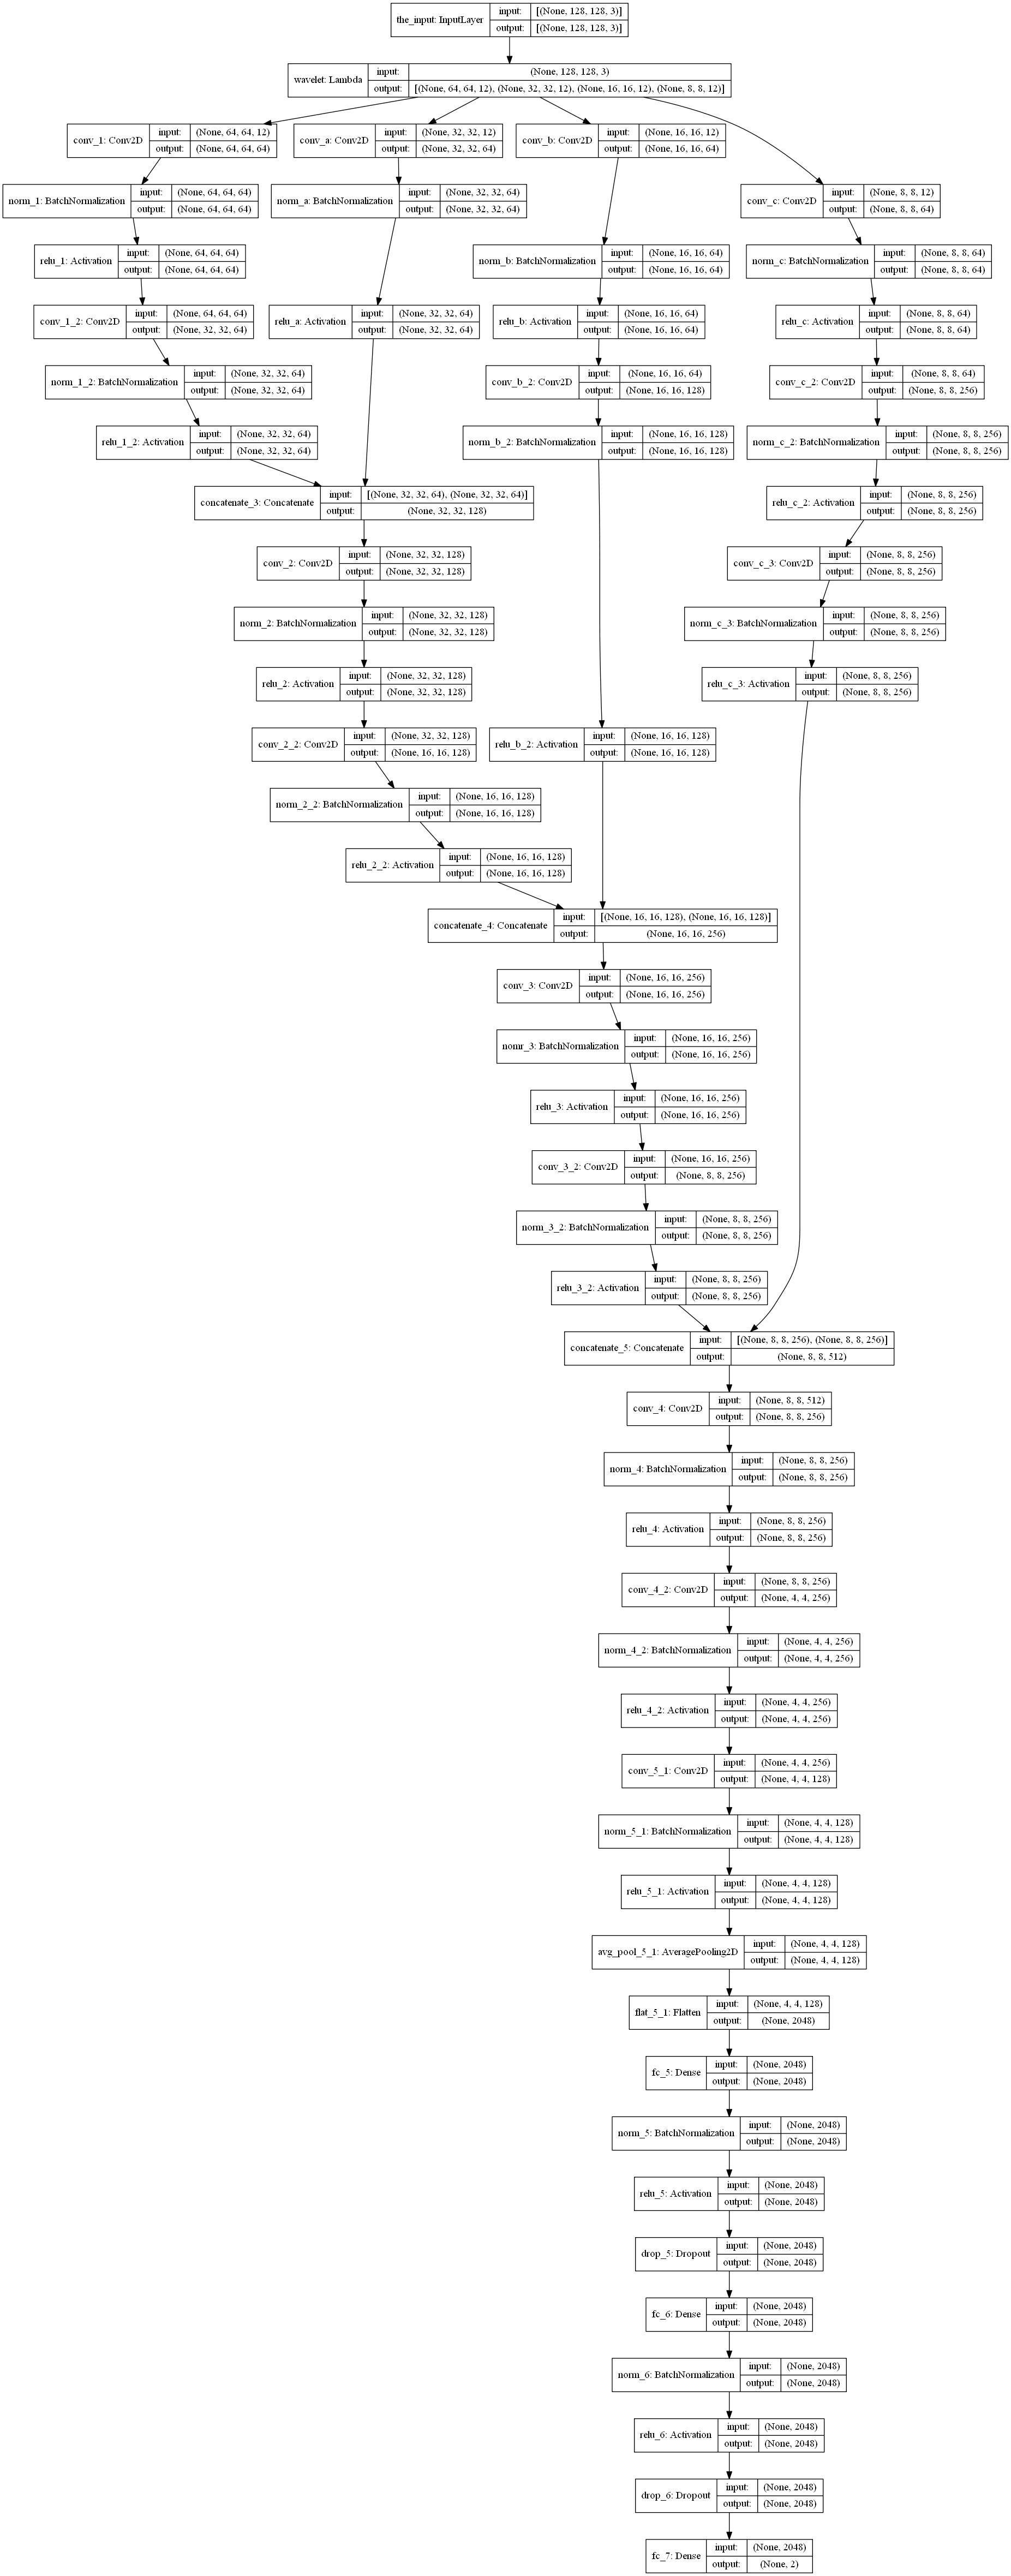

In [15]:
tf.keras.utils.plot_model(dss_model, show_shapes=True)


## new generator model

In [2]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

In [13]:
def defing_generator(latent_size, image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape)
    style_image = Input(shape=image_shape)
    # stack content and style images
    stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(stacked_layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_constraint=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #ouutput layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model
g_model = defing_generator(100)
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 128, 128, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   6208        concatenate_7[0][0]      

In [2]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

def define_generator(latent_size, image_shape=(128, 128, 3)):
    # init layers
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape, name='content_image')
    style_image = Input(shape=image_shape, name='style_image')
    # wavelet transform style_image
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(style_image)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)

    ## wavelet trasform style extraction head
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = Concatenate()([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = Concatenate()([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = Concatenate()([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)

    ## cnn base autoencoder block
    #encoder model
    e1 = define_encoder_block(content_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_constraint=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    g = Conv2DTranspose(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(b)
    g = BatchNormalization()(g, training=True)
    d2 = ReLU()(g)
    #d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, pool_5_1, 512)
    d4 = define_decoder_block(d3, relu_4 , 512, dropout=False)
    d5 = define_decoder_block(d4, relu_3, 256, dropout=False)
    d6 = define_decoder_block(d5, relu_2, 128, dropout=False)
    d7 = define_decoder_block(d6, relu_1, 64, dropout=False)
    #ouutput layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model
ng_model = define_generator(100)
ng_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
style_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 64, 64, 12), 0           style_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 64, 64, 64)   6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 64, 64, 64)   256         conv_1[0][0]                     
__________________________________________________________________________________________

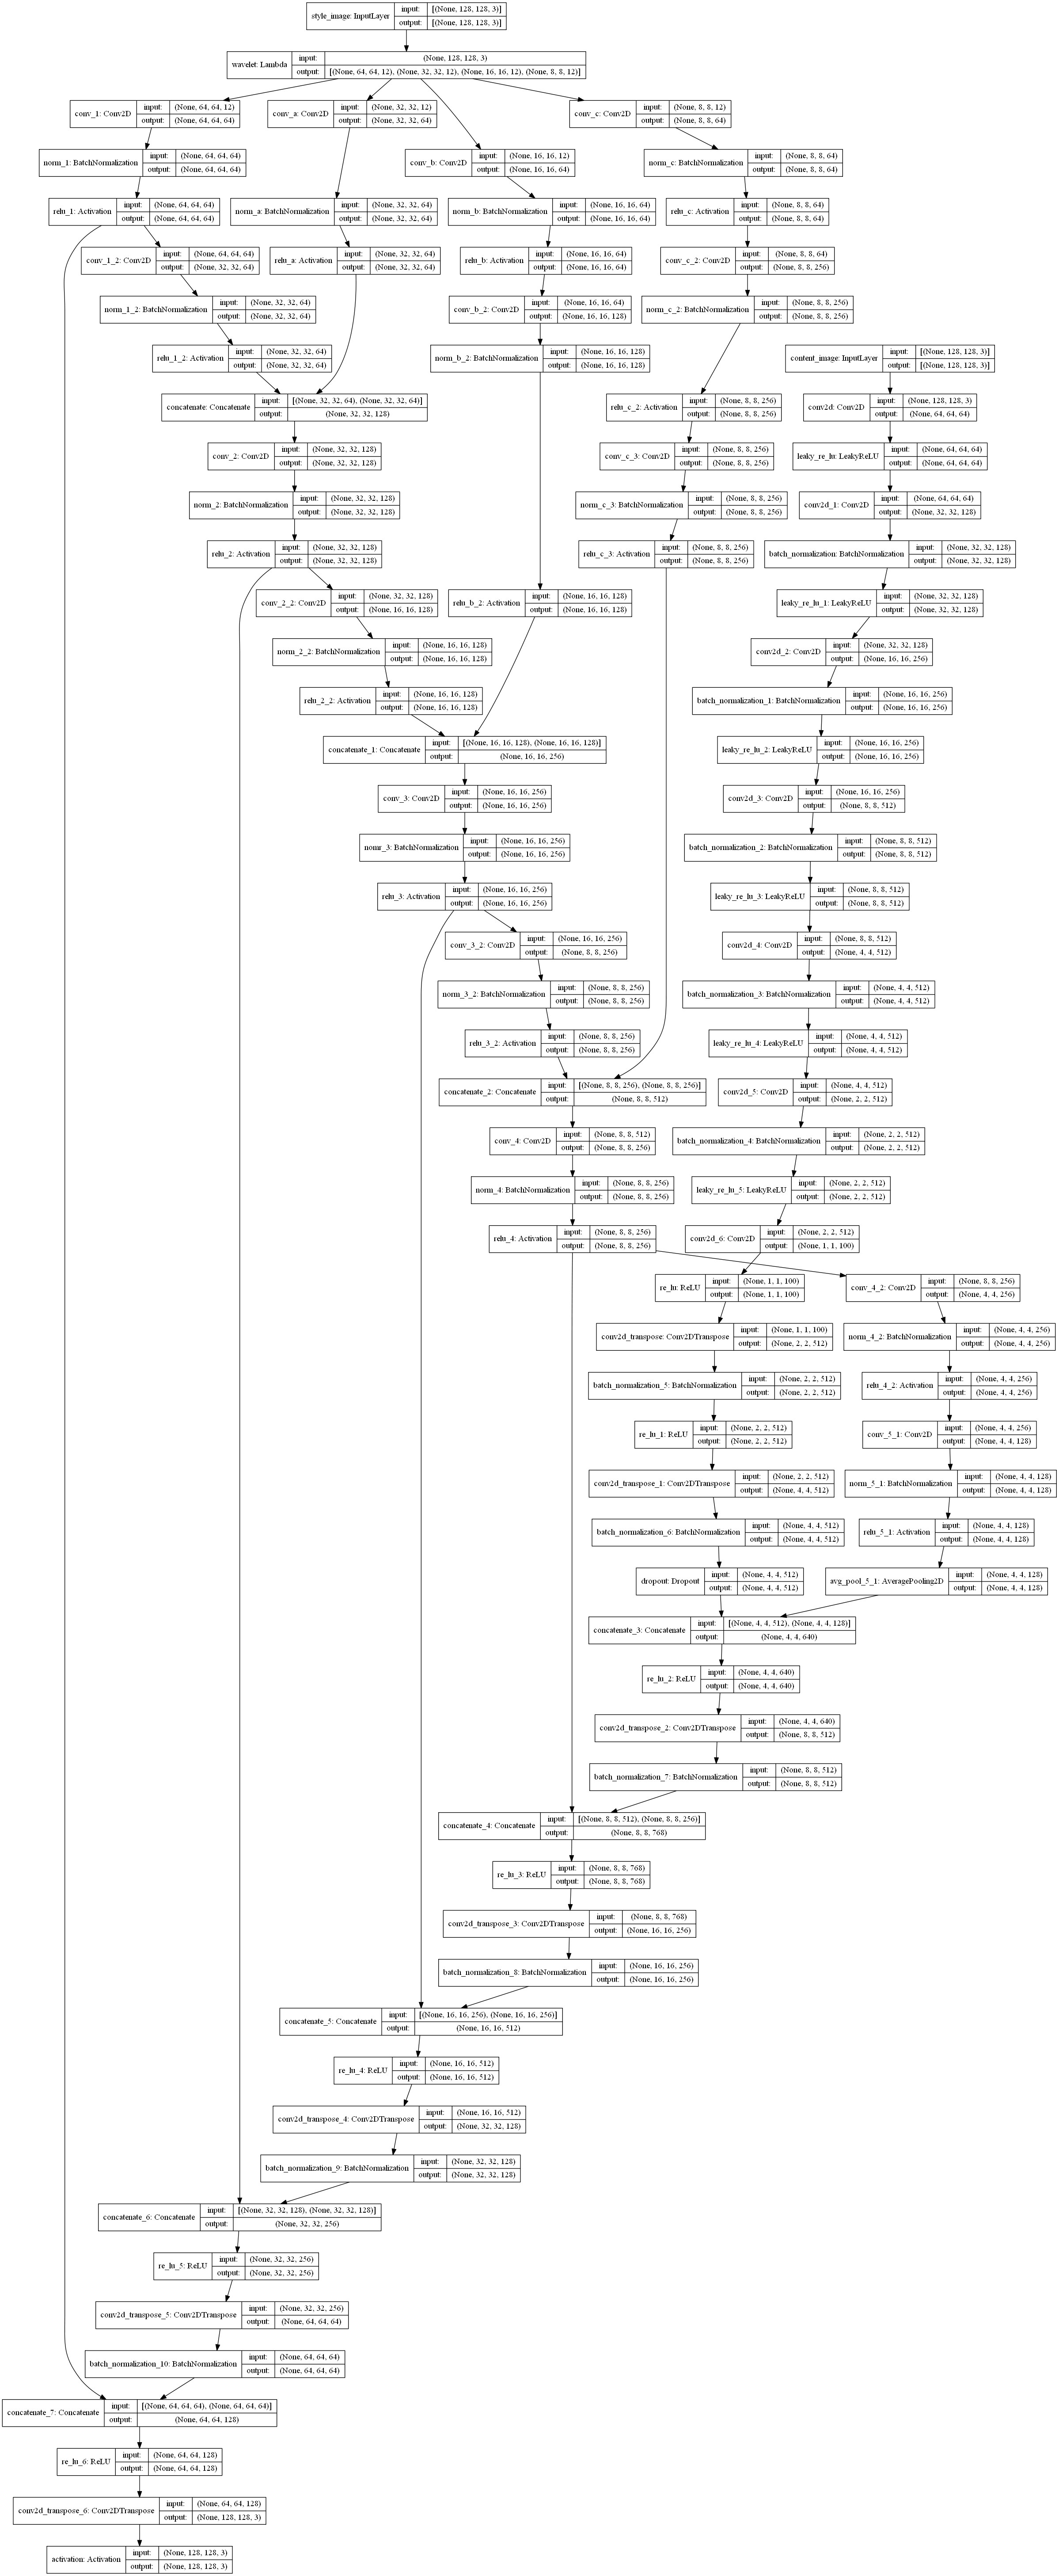

In [3]:
tf.keras.utils.plot_model(ng_model, to_file='gen_model.png', show_shapes=True)

In [2]:
import tensorflow as tf 
vgg16_feature_net = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))
vgg16_feature_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

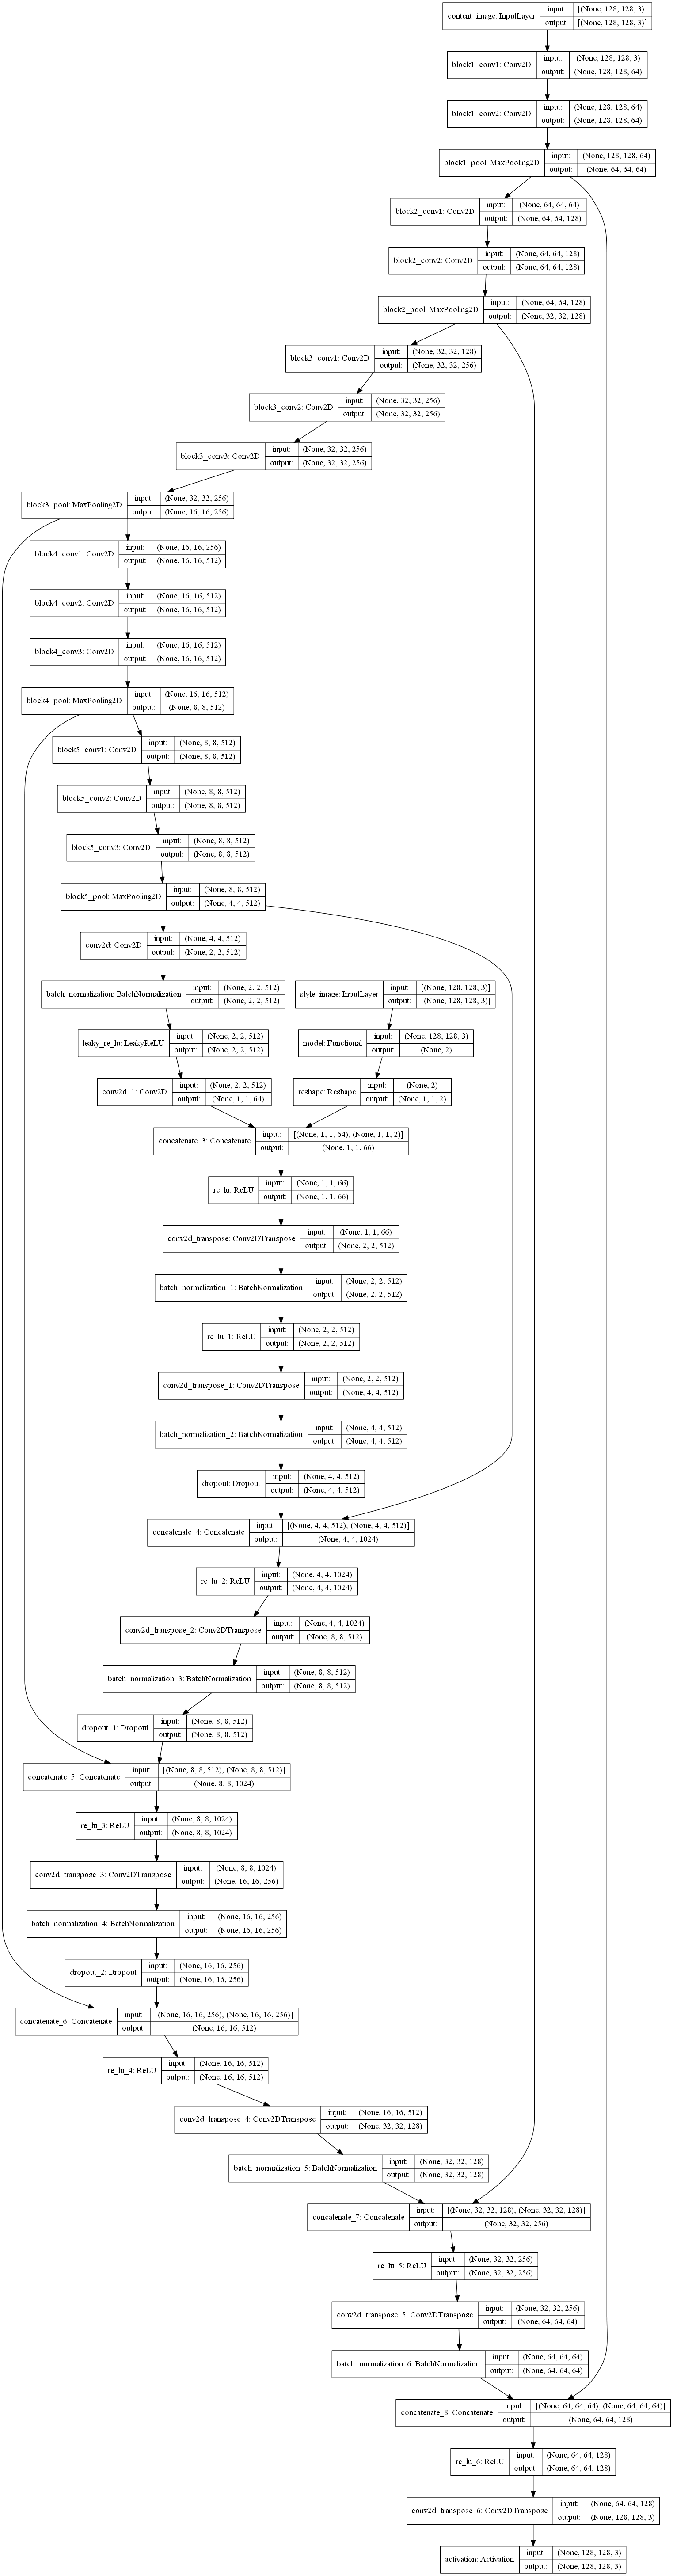

In [14]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    #skip_in = tf.math.l2_normalize(skip_in)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

def define_generator(style_header, latent_size, image_shape=(128, 128, 3)):
    # init layers
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape, name='content_image')
    style_image = Input(shape=image_shape, name='style_image')
    # wavelet transform style_image
    stl_latent_vec = style_header(style_image)
    ## cnn base autoencoder block
    #encoder model
    cgb_model = tf.keras.applications.VGG16(include_top=False, input_shape=image_shape, input_tensor=content_image)
    for layer in cgb_model.layers:
        layer.trainable = False
    vgg_output = cgb_model.output
    e6 = define_encoder_block(vgg_output, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e6)
    stl_latent_mat = Reshape((1, 1, stl_latent_vec.shape[-1]))(stl_latent_vec)
    merged = Concatenate()([b, stl_latent_mat])
    b = ReLU()(merged)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    g = Conv2DTranspose(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(b)
    g = BatchNormalization()(g, training=True)
    d2 = ReLU()(g)
    #d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, cgb_model.get_layer('block5_pool').output, 512)
    d4 = define_decoder_block(d3, cgb_model.get_layer('block4_pool').output , 512, dropout=True)
    d5 = define_decoder_block(d4, cgb_model.get_layer('block3_pool').output, 256, dropout=True)
    d6 = define_decoder_block(d5, cgb_model.get_layer('block2_pool').output, 128, dropout=False)
    d7 = define_decoder_block(d6, cgb_model.get_layer('block1_pool').output, 64, dropout=False)
    #ouutput layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model

g_model = define_generator(dss_model, 64, (128, 128, 3))
tf.keras.utils.plot_model(g_model, show_shapes=True)

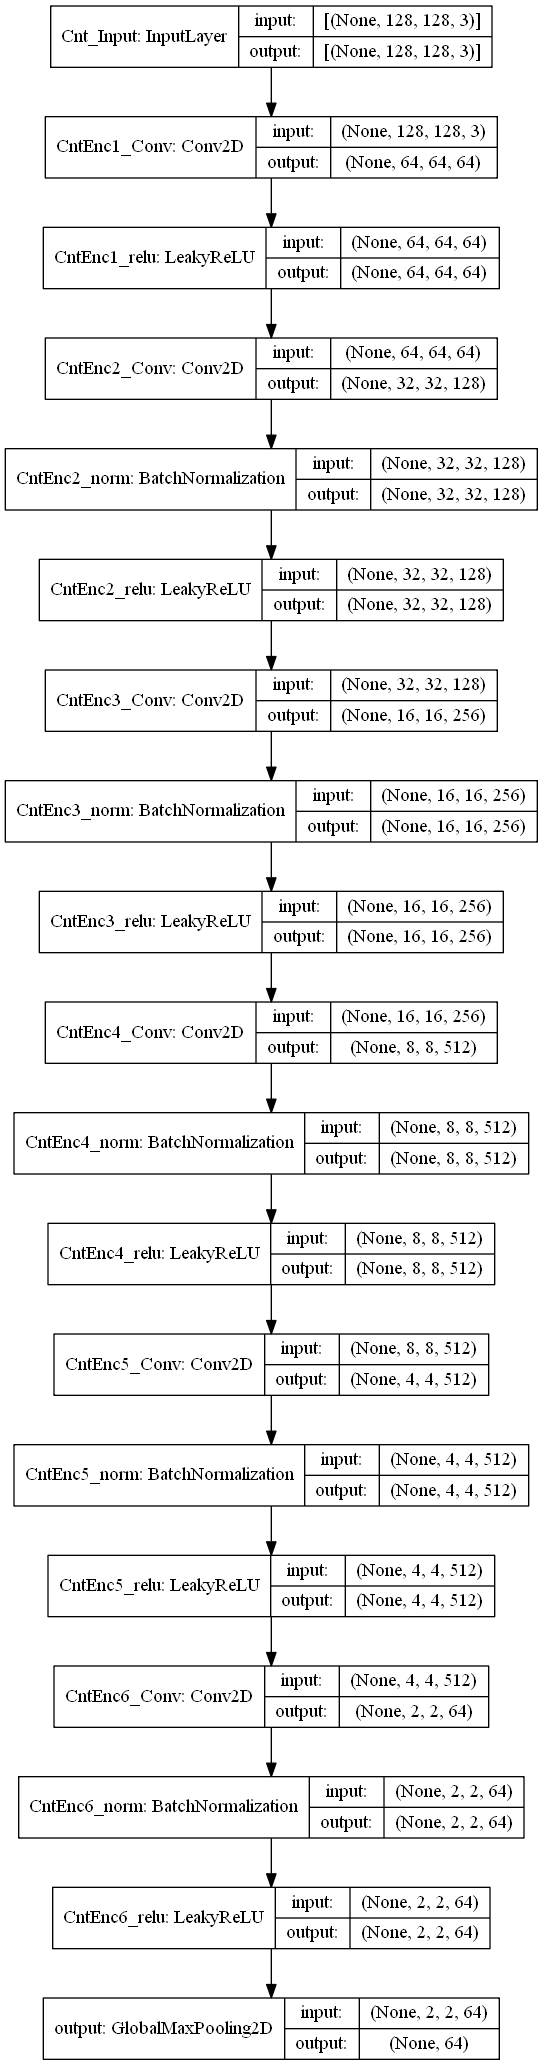

In [2]:
def define_cnt_encoder(latent_size, image_shape=(128, 128, 3)):
    #content image input
    img_in = Input(shape=image_shape, name='Cnt_Input')
    # c64
    d = Conv2D(64, (4, 4), strides=(2,2), padding='same', name='CntEnc1_Conv')(img_in)
    d = LeakyReLU(alpha=0.2, name='CntEnc1_relu')(d)
    # c128
    d = Conv2D(128, (4, 4), strides=(2,2), padding='same', name='CntEnc2_Conv')(d)
    d = BatchNormalization(name='CntEnc2_norm')(d, training=True)
    d = LeakyReLU(alpha=0.2, name='CntEnc2_relu')(d)
    # c256
    d = Conv2D(256, (4, 4), strides=(2,2), padding='same', name='CntEnc3_Conv')(d)
    d = BatchNormalization(name='CntEnc3_norm')(d, training=True)
    d = LeakyReLU(alpha=0.2, name='CntEnc3_relu')(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', name='CntEnc4_Conv')(d)
    d = BatchNormalization(name='CntEnc4_norm')(d, training=True)
    d = LeakyReLU(alpha=0.2, name='CntEnc4_relu')(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', name='CntEnc5_Conv')(d)
    d = BatchNormalization(name='CntEnc5_norm')(d, training=True)
    d = LeakyReLU(alpha=0.2, name='CntEnc5_relu')(d)
    # c-latent size
    d = Conv2D(latent_size, (4, 4), strides=(2,2), padding='same', name='CntEnc6_Conv')(d)
    d = BatchNormalization(name='CntEnc6_norm')(d, training=True)
    d = LeakyReLU(alpha=0.2, name='CntEnc6_relu')(d)
    #output
    output = GlobalMaxPool2D(name='output')(d)

    #define model
    model = Model(inputs=img_in, outputs=output, name='content_base_encoder')
    return model

gc_model = define_cnt_encoder(64)
tf.keras.utils.plot_model(gc_model, show_shapes=True)

In [8]:
feat_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(128, 128, 3))
feat_model.summary()
#tf.keras.utils.plot_model(feat_model, show_shapes=True)

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 63, 63, 32)   96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 63, 63, 32)   0           batch_normalization_812[0][0]    
________________________________________________________________________________

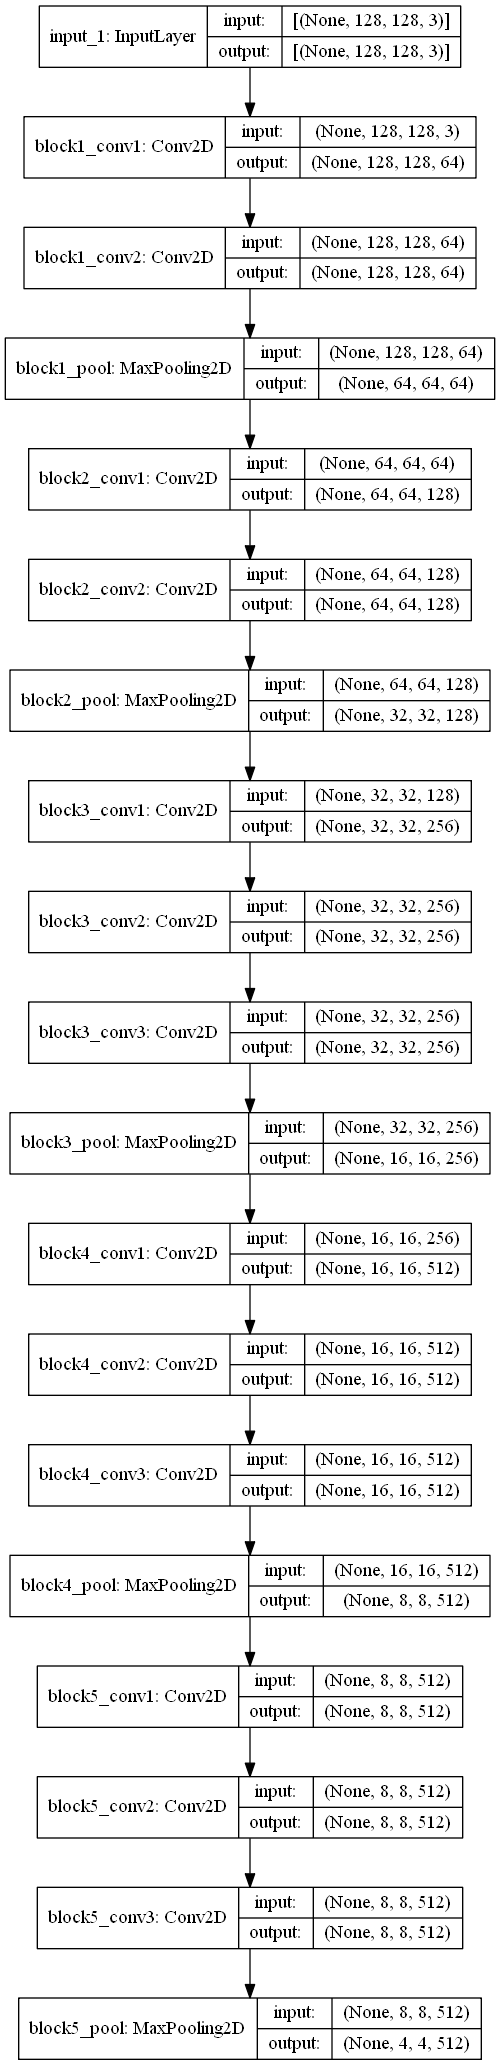

In [2]:
feat_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(128, 128, 3))
#feat_model.summary()
tf.keras.utils.plot_model(feat_model, show_shapes=True)

94674944/94668760 [==============================] - 73s 1us/step


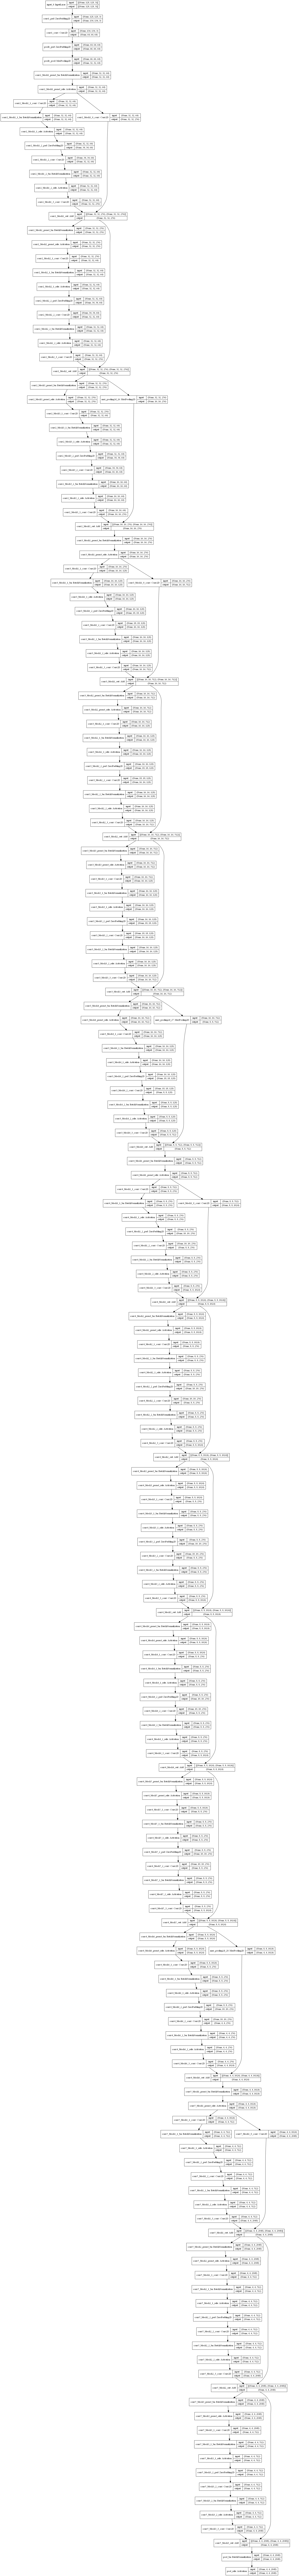

In [10]:
feat_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(128, 128, 3))
#feat_model.summary()
tf.keras.utils.plot_model(feat_model, show_shapes=True)

In [11]:
feat_model = tf.keras.applications.Xception(include_top=False, input_shape=(128, 128, 3))
feat_model.summary()
#tf.keras.utils.plot_model(feat_model, show_shapes=True)

83689472/83683744 [==============================] - 42s 1us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_________________________

In [4]:
feat_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#tf.keras.utils.plot_model(feat_model, show_shapes=True)
t = False
for layer in feat_model.layers:
    if layer.name == "conv5_block16_0_bn":
        t = True 
    layer.trainable=t
feat_model.summary()
# "conv4_block9_0_relu"

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
"conv5_block16_0_bn"